# Selecting high quality receptors
- using matrix multiplications for filtering out receptors
- filtered consensus signature and design matrix are saved to lincs_consensus/hq_newfilter/lm_all_pert_cell_liana_transp.csv and design_matrices/hq_newfilter/all_pert_binary_liana.csv
- filtering out shRNA and CRISPR
- filtering out also inhibitory drugs - all interaction will be positive

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import *
from src.prediction_functions import *
from src.model_creation import *

In [3]:
with open("results/benchmark_LINCS/results_liana_zscore2.json","r") as f:
    all_results = json.load(f)

# Looking for HQ receptors

In [4]:
perturbations = ['cp', 'lig', 'oe', 'xpr', 'sh']

In [5]:
# get all receptors
all_receptor = []
for model in perturbations:
    for data in all_results[model].keys():
        for results in all_results[model][data].keys():
            rocaucs = all_results[model][data][results]['rocauc']
            all_receptor.extend(list(rocaucs.keys()))
all_receptor = set(all_receptor)

In [6]:
rocauc_count_df = pd.DataFrame(columns = ['model', 'data', 'results'] + list(all_receptor))

In [7]:
model_dict = {}
for model in perturbations:
    data_dict = {}
    for data in all_results[model].keys():
        res_dict = {}
        for results in all_results[model][data].keys():
            
            rocaucs = all_results[model][data][results]['rocauc']
            if results == 'negative_results':
            
                rocaucs = {k:(1 if v < 0.4 else 0) for k,v in rocaucs.items()}
                res_dict['negative_results'] = rocaucs
            if results == 'positive_results':
                rocaucs = {k:(1 if v > 0.6 else 0) for k,v in rocaucs.items()}
                res_dict['positive_results'] = rocaucs

                
        data_dict[data] = res_dict
    model_dict[model] = data_dict

In [8]:
flatten_results = pd.DataFrame.from_records(
    [
        (level1, level2, level3, level4, leaf)
        for level1, level2_dict in model_dict.items()
        for level2, level3_dict in level2_dict.items()
        for level3, level4_dict in level3_dict.items()
        for level4, leaf in level4_dict.items()
    ],
    columns=['model', 'data', 'results', 'receptors', 'value']
)

In [28]:
# # exclude sh-xpr xpr-sh validating receptors
# flatten_results_mod = flatten_results.copy()
# def change_value(row):
#     if (row.data == 'sh') & (row.model == 'xpr'):
#         row.value = 0
#     if (row.data == 'xpr') & (row.model == 'sh'):
#         row.value = 0
#     return row
# flatten_results = flatten_results_mod.apply(change_value, axis = 1)


In [9]:
def fill_dataframe(result_row):
    model = result_row.model
    data = result_row.data
    receptor = result_row.receptors
    value = result_row.value
    if value == 1:
        receptor_df_model.loc[receptor, model] += 1
        receptor_df_data.loc[receptor, data] += 1
    return

In [10]:
receptor_df_model = pd.DataFrame(0, index = flatten_results.receptors.unique(), columns = list(set(flatten_results.model) | set(flatten_results.data)))
receptor_df_data = pd.DataFrame(0, index = flatten_results.receptors.unique(), columns = list(set(flatten_results.model) | set(flatten_results.data)))
_x = flatten_results.apply(fill_dataframe, axis = 1)
receptor_df = receptor_df_model + receptor_df_data

In [11]:
receptor_df.head()

,lig,sh,cp,xpr,oe
CALCRL,1,0,2,1,0
IGF1R,1,2,3,0,2
TEK,0,1,1,0,0
GCGR,0,0,2,2,0
AXL,1,0,1,0,0


# Create merged signature

In [13]:
def read_in_data_for_model_creation(pert_type, genes_filename = 'lm'):
    print('Read in signature')
    signature = pd.read_csv(f'data/lincs_consensus/{genes_filename}_{pert_type}_pert_cell_liana.csv', index_col = 0)
    return signature

In [14]:
data = {}
for pert_type in perturbations:
    print(pert_type, end = ': ')
    data[pert_type] = read_in_data_for_model_creation(pert_type, genes_filename = 'lm')
    data[pert_type].index = data[pert_type].index + '_' + pert_type

cp: Read in signature
lig: Read in signature
oe: Read in signature
xpr: Read in signature
sh: Read in signature


In [15]:
design_matrices = {}
for pert_type in perturbations:
    print(pert_type, end =': ')
    print('Read in signature')
    design_matrices[pert_type] = pd.read_csv(f'data/design_matrices/{pert_type}_pert_binary_liana.csv', index_col =0 )
    design_matrices[pert_type].index = design_matrices[pert_type].index + '_' + pert_type


cp: Read in signature
lig: Read in signature
oe: Read in signature
xpr: Read in signature
sh: Read in signature


In [16]:
def merge_signatures(data, design_matrices):
    data_all = pd.DataFrame(columns = data[list(data.keys())[0]].columns)
    for i in data:
        data_all = pd.concat([data_all, data[i].loc[design_matrices[i].index]])
    data_all = data_all.astype('float')
    return data_all

In [17]:
def merge_design_matrces(gene_list, pert_list, design_matrices):
    df = pd.DataFrame(columns = gene_list, index = pert_list)
    for i in design_matrices:
        df.loc[design_matrices[i].index, design_matrices[i].columns] = design_matrices[i]
    df = df.fillna(0)
    df = df.astype('int')
    return df

In [18]:
def merge_data(design_matrices, data):
    # receptor list
    gene_list = []
    f = list(map(lambda y: gene_list.extend(y.columns), design_matrices.values()))
    gene_list = list(set(gene_list))
    # perturbations (cell_pert_list)
    pert_list = []
    f = list(map(lambda y: pert_list.extend(y.index), design_matrices.values()))
    print('Merge design matrices')
    dms = merge_design_matrces(gene_list, pert_list, design_matrices)
    print('Merge signatures')
    data_all = merge_signatures(data, design_matrices)
    return dms, data_all


In [19]:
designmatrix, gexdata = merge_data(design_matrices, data)

Merge design matrices
Merge signatures


In [20]:
designmatrix.to_csv(f'data/design_matrices/all_pert_binary_liana.csv')
gexdata.to_csv(f'data/lincs_consensus/lm_all_pert_cell_liana.csv')

### Multiply (dot) good receptor matrix and design matrix (which receptor is perturbed in samples)
 - sample_perturbation_df_dummy: pd.DataFrame: samples x perturbation_type (which sample which type of perturbation (cp, lig, xpr...))
 - receptor_df: pd.DataFrame: which is the good receptor and in which perturbation type (eg. cp model can predict SMAD3 in sh data -> sh and cp at SMAD3 = 1)
 - sample_receptor_matrix: pd.DataFrame: dot product of sample_perturbation_df_dummy and receptor_df, samples x receptors dimension
### Multiply (scalar)

In [20]:
sample_perturbation_df = pd.DataFrame(gexdata.index.str.split('_', expand = True).get_level_values(2), index = gexdata.index, columns = ['pert_type'])

In [21]:
sample_perturbation_df_dummy = pd.get_dummies(sample_perturbation_df, prefix = '', prefix_sep = '')
# take care of same column order
sample_perturbation_df_dummy = sample_perturbation_df_dummy.loc[:, receptor_df.columns]


In [22]:
sample_receptor_matrix = pd.DataFrame(np.dot(sample_perturbation_df_dummy, receptor_df.T), 
                                index = sample_perturbation_df_dummy.index, columns = receptor_df.index)

In [23]:
sample_receptor_matrix.iloc[0:4, 0:10]

,CALCRL,IGF1R,TEK,GCGR,AXL,HCRTR2,SMAD3,FGFR4,IL5RA,HTR2A
2-PMDQ_U2OS_cp,2,3,1,2,1,1,2,1,2,0
2-iodomelatonin_U2OS_cp,2,3,1,2,1,1,2,1,2,0
2-phenylmelatonin_U2OS_cp,2,3,1,2,1,1,2,1,2,0
3-matida_A375_cp,2,3,1,2,1,1,2,1,2,0


In [24]:
sample_order = list(sample_receptor_matrix.index)
receptor_order = list(sample_receptor_matrix.columns)

In [25]:
designmatrix = designmatrix.loc[sample_order, receptor_order]

In [26]:
# create absolute values of design matrix (if inhibition) 
# because we need only good receptors 
# that are perturbed and have a high ROCAUC in model and data 
# a receptor is good if a model can predict in data type
designmatrix_abs = designmatrix.abs()
# check if only 0 and 1 values exist
# np.unique(designmatrix_abs.values)

In [27]:
results = designmatrix_abs * sample_receptor_matrix

In [28]:
# filter out sampels that do not have good receptors
res2 = results[results.sum(1) > 0]
len(res2)

15744

<AxesSubplot:>

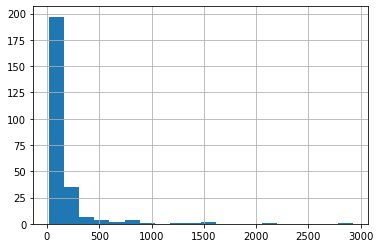

In [29]:
# histogram of nonzero receptors
res2.T[res2.sum() > 0].sum(1).hist(bins = 20)

In [30]:
len(res2.T[res2.sum() > 0])

255

In [31]:
hq_samples = res2.loc[:, res2.sum() > 0].index
hq_receptos = res2.loc[:, res2.sum() > 0].columns

In [32]:
designmatrix.loc[hq_samples, hq_receptos].to_csv(f'data/design_matrices/high_quality/all_pert_binary_liana.csv')

In [33]:
gexdata.loc[hq_samples, :].to_csv(f'data/lincs_consensus/high_quality/lm_all_pert_cell_liana.csv')

In [34]:
gexdata.loc[hq_samples, :].T.to_csv(f'data/lincs_consensus/high_quality/lm_pert_cell_liana_transp.csv')

# Fit model on high quality receptors

In [35]:
dms = pd.read_csv(f'data/design_matrices/high_quality/all_pert_binary_liana.csv', index_col = 0)
data = pd.read_csv(f'data/lincs_consensus/high_quality/lm_all_pert_cell_liana.csv', index_col = 0)

In [36]:
data.shape, dms.shape

((15744, 978), (15744, 255))

In [37]:
coeff_m = fit_linear_model_and_get_coefficients_by_receptor(y = data, X = dms)

In [38]:
def save_coeffitient_matrix(coeff_matrix, model_name):
    path = f'data/coefficient_matrix/high_quality/{model_name}_pert_coef_liana.csv'
    print('Save coefficient matrix to '+  path)
    coeff_matrix.to_csv(path)
    print('Done')

In [39]:
save_coeffitient_matrix(coeff_m, 'all')

Save coefficient matrix to data/coefficient_matrix/high_quality/all_pert_coef_liana.csv
Done
